### Figures for prediction (root_t = 0)

In [1]:
running_on = "jupyter" # "colab", "jupyter", "cluster"

In [2]:
import time
start_time = time.time()

In [3]:
if running_on == "cluster":
    # To run as a python file in cluster
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--patient_number", help="patient to select data", type=int)
    parser.add_argument("--N", help="number of training points", type=int)
    parser.add_argument("--train_data", help="load_data or compute_points", type=str)
    parser.add_argument("--nIter", help="number of iterations", type=int)
    parser.add_argument("--criterion", help="criterion for bayesian opt.", type=str)
    parser.add_argument("--opt_points", help="load_opt_points or run_opt", type=str)
    # parser.add_argument("--var_parameters_list",
                        # nargs='+',
                        # help="parameters to find, select from: init_length, length, fascicles_length, fascicles_angles, branch_angle")
    args = parser.parse_args()

    patient_number       = args.patient_number
    N                    = args.N
    obtain_training_data = args.train_data
    nIter                = args.nIter
    criterion_bo         = args.criterion
    optimization_points  = args.opt_points
    # var_parameters_list = args.var_parameters_list

elif running_on == "colab" or running_on == "jupyter":
    # To run on colab or jupyter
    patient_number       = 1
    N                    = 250 
    obtain_training_data = "load_data" # "compute_points" # 
    nIter                = 300 
    criterion_bo         = "EI" #"LCB" #
    optimization_points  = "load_opt_points" # "run_opt" #

In [4]:
print ( "#####################################")
print (f"Running analysis of patient {patient_number}")
print (f"N = {N}, {obtain_training_data}            ") 
print (f"nIter = {nIter}, {optimization_points}  ")
print ( "#####################################")

#####################################
Running analysis of patient 1
N = 250, load_data            
nIter = 300, load_opt_points  
#####################################


In [5]:
if running_on == "cluster":
    # To run as a python file in cluster
    import os
    import sys
    os.chdir('./PurkinjeECG')
    sys.path.insert(0, os.getcwd())
    
elif running_on == "jupyter":
    %cd ./PurkinjeECG
    %reload_ext autoreload
    %autoreload 2
    
elif running_on == "colab":
    %cd "/content/PurkinjeECG"
    %reload_ext autoreload
    %autoreload 2

# from bo_purkinje import BO_Purkinje

/mnt/sdb/Pipe/Proyectos_FS/Codes/purkinje-learning-paper/preliminary_figures/PurkinjeECG


In [6]:
import numpy as onp
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)

# from jax import random, lax
# from jaxbo.models import GP
# from jaxbo.utils import normalize

import matplotlib.pyplot as plt
import os 
import pickle

# onp.random.seed(1234)

### Set variables

In [7]:
# mse_jaxbo
dim = 2

def var_parameters_dict(var_parameters_names):
    var_parameters = {}
    
    # init_length
    if "init_length" in var_parameters_names:
        lb_init_length  = 30.0 * np.ones(dim) # 5
        ub_init_length  = 100.0 * np.ones(dim) # 55
        var_parameters["init_length"] = [lb_init_length, ub_init_length, "uniform"]
        # true_x += [30, 36.44783584]

    # length
    if "length" in var_parameters_names:
        lb_length = 4. * np.ones(1)
        ub_length = 12. * np.ones(1)
        var_parameters["length"] = [lb_length, ub_length, "uniform"]
        # true_x += [length, length]

    # w
    if "w" in var_parameters_names:
        lb_w = 0.05* np.ones(1) # 0.05
        ub_w = 0.25 * np.ones(1) # 0.8
        var_parameters["w"] = [lb_w, ub_w, "uniform"]
        # true_x += [w, w]

    # l_segment
    if "l_segment" in var_parameters_names:
        lb_l_segment = 1. * np.ones(dim)
        ub_l_segment = 15. * np.ones(dim)
        var_parameters["l_segment"] = [lb_l_segment, ub_l_segment, "uniform"]
        # true_x += [l_segment, l_segment]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        lb_fascicles_length = 2.0 * np.ones(2*dim) # 10 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_length = 50.0 * np.ones(2*dim) # 30
        var_parameters["fascicles_length"] = [lb_fascicles_length, ub_fascicles_length, "uniform"]
        # true_x += 2 * f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        lb_fascicles_angles = -1./4. * onp.pi * np.ones(2*dim) # 0.1 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_angles = 3./4. * onp.pi * np.ones(2*dim) # 1.57
        var_parameters["fascicles_angles"] = [lb_fascicles_angles, ub_fascicles_angles, "uniform"]
        # true_x += 2 * f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        lb_branch_angle  = 5. * onp.pi/180. * np.ones(1)
        ub_branch_angle  = 45. * onp.pi/180. * np.ones(1)
        var_parameters["branch_angle"] = [lb_branch_angle, ub_branch_angle, "uniform"]
        # true_x += [branch_angle, branch_angle]
    
    # root_time
    if "root_time" in var_parameters_names:
        lb_root_time  = -75. * np.ones(1)
        ub_root_time  = 50. * np.ones(1)
        var_parameters["root_time"] = [lb_root_time, ub_root_time, "uniform"]
        
    # cv
    if "cv" in var_parameters_names:
        lb_cv  = 2. * np.ones(1)
        ub_cv  = 4. * np.ones(1)
        var_parameters["cv"] = [lb_cv, ub_cv, "uniform"]
        
    return var_parameters

In [8]:
var_parameters_list = ["init_length", "fascicles_length", "fascicles_angles","root_time", "cv"]
var_parameters = var_parameters_dict(var_parameters_list)

### Create ecgs

In [9]:
# patients_selected = [patient_number, patient_number, patient_number, patient_number]
patients_selected = [1, 4, 12, 17]
n_patients = len(patients_selected)

# # Load results
list_variable_params = "_".join(list(var_parameters.keys()))

patients_results = []
qrs_in_pred, qrs_fin_pred = 0, 200 # 500
for pat_n in patients_selected:
    name_ecg = f"./output/predict_root_time0/patient{pat_n}_ecg_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}"
    ecg_n = pickle.load(open(name_ecg, "rb"))
    
    ecg_sel = []
    for ecg_i in ecg_n:
        ecg_sel.append(ecg_i[qrs_in_pred:qrs_fin_pred])
    patients_results.append(ecg_sel)

# ecg_leads_names = ('E1', 'E2', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'E3', 'aVR', 'aVL', 'aVF')
ecg_leads_names = ('E1', 'E2', 'E3', 'aVR', 'aVL', 'aVF','V1', 'V2', 'V3', 'V4', 'V5', 'V6')

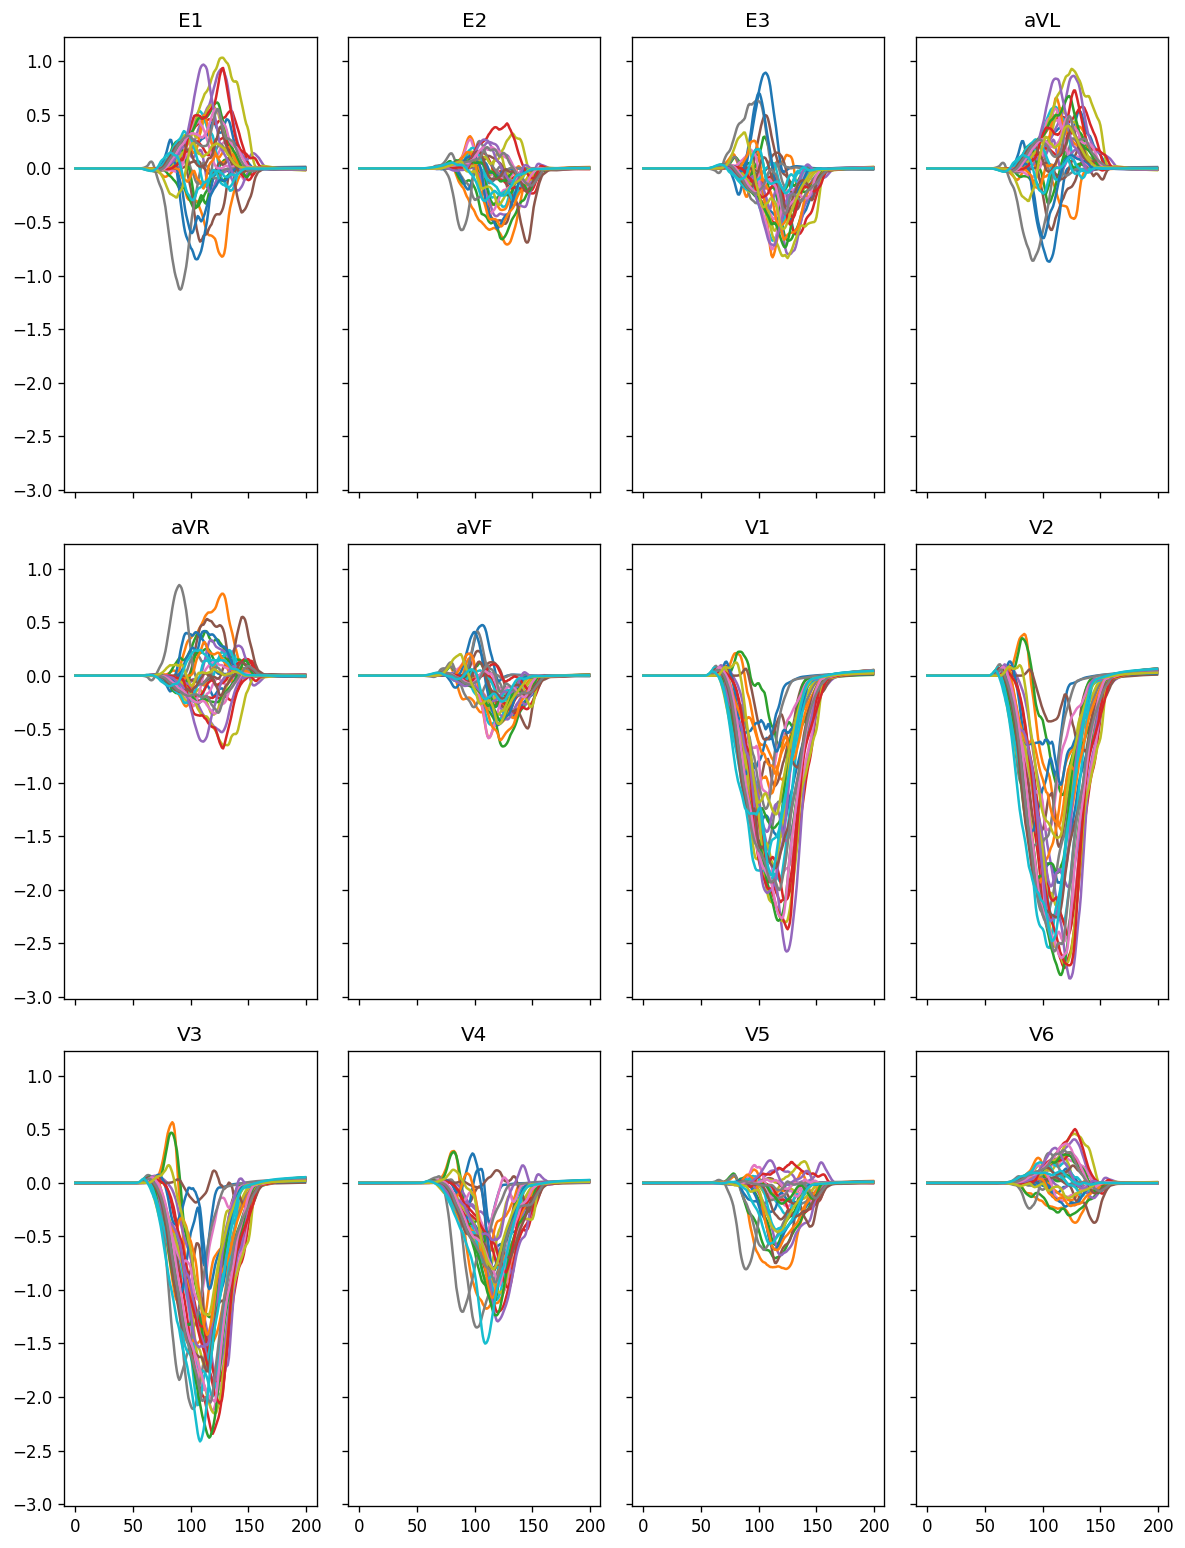

In [10]:
### TEST ###
# ecgs of trees with root_time = 0
pat_result_ind = 0
fig,axs = plt.subplots(3,4,figsize=(10,13),dpi=120,sharex=True,sharey=True)
for ax,l in zip(axs.ravel(),patients_results[pat_result_ind][0].dtype.names):
#     for pat_ecgs in patients_results:
#         for ecg_ind in pat_ecgs:
#             ax.plot(ecg_ind[l])
    for ecg_ind in patients_results[pat_result_ind]: # [25:30]
        ax.plot(ecg_ind[l])
    
#     ax.grid()
    ax.set_title(l)
    
fig.tight_layout()
plt.show()
### TEST ###

In [11]:
import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('../Helvetica Neue Bold.ttf')
matplotlib.rc('font', family='Helvetica Neue')


plt.rcParams['font.family'] = u'Helvetica Neue'


plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] ='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18

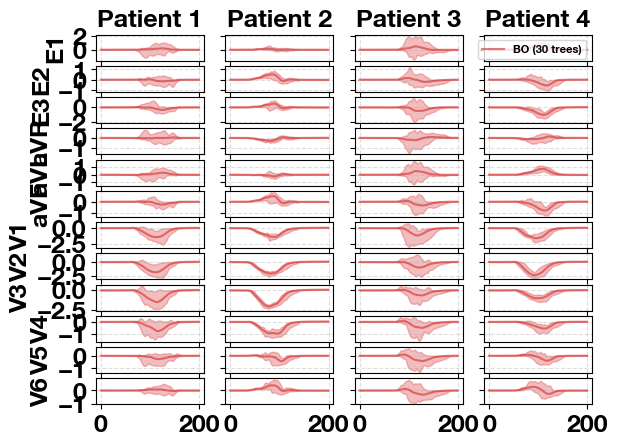

In [12]:
# Find y limits
fig,axs = plt.subplots(12, n_patients, sharex=True, sharey='row')
for lead_i in onp.arange(len(ecg_leads_names)):
    for pat_i in onp.arange(n_patients):
        ax = axs[lead_i, pat_i]
        l  = ecg_leads_names[lead_i]
        
#         pat_class = patients_results[pat_i]
        pat_selection_ecg = patients_results[pat_i]

        #         # real ecg
#         mean_ecgs = pat_class.ecg_pat_mean[l][0:600]
#     #     std_ecgs  = pat_class.ecg_pat_std[l][0:600]    
#         min_ecgs  = pat_class.ecg_pat_min[l][0:600]
#         max_ecgs  = pat_class.ecg_pat_max[l][0:600]

#         ax.plot(mean_ecgs,'tab:blue', alpha=0.6, label="Ground truth")
#         ax.fill_between(np.arange(len(min_ecgs)), min_ecgs, max_ecgs, color='tab:blue', alpha=.3)

        # predicted ecgs
        n_sel  = len(pat_selection_ecg)
        n_time = len(pat_selection_ecg[0])
    
        ecg_l = onp.empty((n_sel, n_time))
        for ind in onp.arange(n_sel):
            ecg_l[ind, :] = pat_selection_ecg[ind][l]
    
        mean_l = np.mean(ecg_l, axis=0)
#         std_l  = np.std(ecg_l, axis=0)
        min_l  = np.min(ecg_l, axis=0)
        max_l  = np.max(ecg_l, axis=0)
    
        label_BO = "BO (" + str(n_sel) + " trees)"
        ax.plot(qrs_in_pred + np.arange(len(mean_l)), mean_l,'tab:red', alpha=0.6, label=label_BO)
        ax.fill_between(qrs_in_pred + np.arange(len(min_l)), min_l, max_l, color='tab:red', alpha=.3)

        ax.grid(linestyle='--',alpha=0.4)
#         ax.set_xlim((0,600))
        if pat_i == 0:
            ax.set_ylabel(l)
        
        if lead_i == 0:
            ax.set_title(f"Patient {pat_i + 1}")
            
        if lead_i == 0 and pat_i == n_patients - 1:
            ax.legend(fontsize="8")
            
# Calculate normalized heights based on y-limits
heights = []
for lead_i in onp.arange(len(ecg_leads_names)):
    ax = axs[lead_i, 0]
    heights += [ax.get_ylim()[1] - ax.get_ylim()[0]]

In [16]:
fig,axs = plt.subplots(12, n_patients,
                       figsize=(12,20),
                       dpi=120,
                       gridspec_kw={'height_ratios': heights},
                       sharex=True, sharey='row')

for lead_i in onp.arange(len(ecg_leads_names)):
    for pat_i in onp.arange(n_patients):
        ax = axs[lead_i, pat_i]
        l = ecg_leads_names[lead_i]
        
#         pat_class = patients_results[pat_i]
        pat_selection_ecg = patients_results[pat_i]
        
#         # real ecg
#         mean_ecgs = pat_class.ecg_pat_mean[l][0:600]
#     #     std_ecgs  = pat_class.ecg_pat_std[l][0:600]    
#         min_ecgs  = pat_class.ecg_pat_min[l][0:600]
#         max_ecgs  = pat_class.ecg_pat_max[l][0:600]

#         ax.plot(mean_ecgs,'tab:blue', alpha=0.6, label="Ground truth")
#         ax.fill_between(np.arange(len(min_ecgs)), min_ecgs, max_ecgs, color='tab:blue', alpha=.3)

        # predicted ecgs
        n_sel  = len(pat_selection_ecg)
        n_time = len(pat_selection_ecg[0])
    
        ecg_l = onp.empty((n_sel, n_time))
        for ind in onp.arange(n_sel):
            ecg_l[ind, :] = pat_selection_ecg[ind][l]
    
        mean_l = np.mean(ecg_l, axis=0)
#         std_l  = np.std(ecg_l, axis=0)
        min_l  = np.min(ecg_l, axis=0)
        max_l  = np.max(ecg_l, axis=0)
    
        label_BO = "BO (" + str(n_sel) + " samples)"
        ax.plot(qrs_in_pred + np.arange(len(mean_l)), mean_l,'tab:red', alpha=0.6, label=label_BO)
        ax.fill_between(qrs_in_pred + np.arange(len(min_l)), min_l, max_l, color='tab:red', alpha=.3)
        
        # ax.grid(linestyle='--',alpha=0.4)
        ax.set_axis_off()

#         ax.set_xlim((0,600))
        if pat_i == 0:
            # ax.set_ylabel(l)
            ax.text(-0.1, 0.5, l, rotation=90, va='center', ha='center', transform=ax.transAxes, fontsize=14)
        
        if lead_i == 0:
            ax.set_title(f"patient {pat_i + 1}", fontsize=14)
            
        # if lead_i == 0 and pat_i == n_patients - 1:
        #     ax.legend(fontsize="8")

# Legend
handles, labels = axs[0,0].get_legend_handles_labels() 
legend = fig.legend(handles, labels, loc = 'upper left', bbox_to_anchor = (0.785,0.), fontsize="14", frameon = False)

fig.tight_layout()
fig.align_ylabels()
plt.subplots_adjust(hspace=-0.025, wspace = 0.05)
fig.savefig("Fig_prediction_final_ecgs.pdf", bbox_inches='tight')

In [14]:
end_time = time.time()
print("Elapsed time: " + str(end_time - start_time))

Elapsed time: 18.98344135284424
